<a href="https://colab.research.google.com/github/hyakuroume/Generative_AI/blob/develop/compressing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install -q genaibook

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.4/290.4 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 133.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 62.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 49.8 MB/s eta 0:00:00


## データの準備

In [30]:
from datasets import load_dataset

# MINSITデータセットのロード
mnist = load_dataset("mnist")
mnist

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [3]:
# 28pixel*28pixelの手書き数字の画像
mnist["train"]["image"][0]

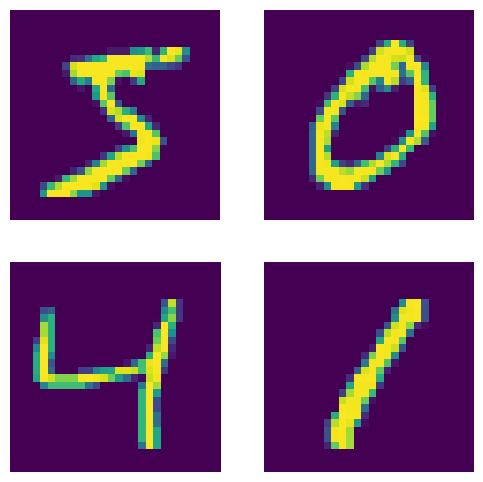

In [7]:
# 高解像度で表示
from genaibook.core import show_images

show_images(mnist["train"]["image"][:4])

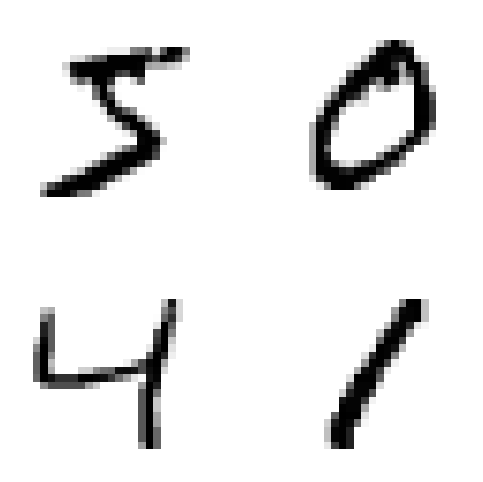

In [8]:
# 白黒で表示
import matplotlib as mpl

mpl.rcParams["image.cmap"] = "gray_r"
show_images(mnist["train"]["image"][:4])

In [26]:
from torchvision import transforms

def mnist_to_tensor(samples):
    """
    mnistデータセットを受け取り、PyTorchテンソルに変換する

    Args:
        samples (dict): mnistデータセットのサンプル

    Returns:
        dict: PyTorchテンソルに変換されたサンプル
    """
    t = transforms.ToTensor()
    samples["image"] = [t(image) for image in samples["image"]]
    return samples

In [31]:
# データをPyTorchテンソルに変換し、訓練データセットをシャッフル
mnist = mnist.with_transform(mnist_to_tensor)
mnist["train"] = mnist["train"].shuffle(seed=1337)

In [32]:
# データの確認(0~1の範囲になっているか)
x = mnist["train"]["image"][0]
x.min(), x.max()

(tensor(0.), tensor(1.))

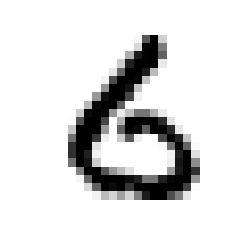

In [33]:
show_images(mnist["train"]["image"][0])

In [34]:
# DataLoaderの作成
from torch.utils.data import DataLoader

bs = 64
train_dataloader = DataLoader(mnist["train"]["image"], batch_size=bs)

## エンコーダーのモデリング

In [40]:
from torch import nn

def conv_block(in_channels, out_channels, kernel_size=4, stride=2, padding=1):
    return nn.Sequential(
        nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding
        ),

        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
    )

In [41]:
class Encoder(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv1 = conv_block(in_channels, 128)
        self.conv2 = conv_block(128, 256)
        self.conv3 = conv_block(256, 512)
        self.conv4 = conv_block(512, 1024)
        self.linear = nn.Linear(1024, 16)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        # バッチの次元数を保持したまま平坦化
        x = self.linear(x.flatten(start_dim=1))
        return x

In [42]:
# サイズの確認
mnist["train"]["image"][0].shape

torch.Size([1, 28, 28])

In [45]:
in_channels = 1

x = mnist["train"]["image"][0][None, :]
encoder = Encoder(in_channels).eval()

encoded = encoder(x)
encoded.shape

torch.Size([1, 16])

In [46]:
encoded

tensor([[-0.0257, -0.0029, -0.0080, -0.0003,  0.0034,  0.0181, -0.0356,  0.0325,
          0.0147, -0.0342,  0.0247, -0.0073, -0.0083,  0.0061, -0.0029, -0.0268]],
       grad_fn=<AddmmBackward0>)

In [47]:
# バッチに対応できているか確認
batch = next(iter(train_dataloader))
encoded = Encoder(in_channels)(batch)

batch.shape, encoded.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64, 16]))

## デコーダー

In [51]:
def conv_transposed_block(
        in_channels,
        out_channels,
        kernel_size=3,
        stride=2,
        padding=1,
        output_padding=0,
        with_act=True
):
    """
    転地畳み込み

    Args:
        in_channels (int): 入力チャネル数
        out_channels (int): 出力チャネル数

    Return:
        nn.Sequential: 転地畳み込み層のレイヤーブロック
    """

    modules = [
        nn.ConvTranspose2d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            output_padding=output_padding,
        ),
    ]

    if with_act:
        modules.append(nn.BatchNorm2d(out_channels))
        modules.append(nn.ReLU())

    return nn.Sequential(*modules)

In [54]:
class Decoder(nn.Module):
    def __init__(self, out_channels):
        super().__init__()

        self.linear = nn.Linear(16, 1024 * 4 * 4)
        self.t_conv1 = conv_transposed_block(1024, 512)
        self.t_conv2 = conv_transposed_block(512, 256, output_padding=1)
        self.t_conv3 = conv_transposed_block(256, out_channels, output_padding=1)

    def forward(self, x):
        bs = x.shape[0]
        x = self.linear(x)
        x = x.reshape((bs, 1024, 4, 4))

        x = self.t_conv1(x)
        x = self.t_conv2(x)
        x = self.t_conv3(x)

        return x

In [55]:
decoded_batch = Decoder(x.shape[0])(encoded)
decoded_batch.shape

torch.Size([64, 1, 28, 28])